<a href="https://colab.research.google.com/github/Kwannn666/DL_Report2/blob/main/DL_Report2_Replay_buffer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import json
from pathlib import Path
from tqdm import tqdm
import urllib.request
import tarfile
import zipfile

# --- 參數設定 ---
# 固定亂數種子，確保每次抽樣結果一致
random.seed(42)
# 資料集圖片數量
NUM_TRAIN = 240
NUM_VAL = 60
NUM_TOTAL = NUM_TRAIN + NUM_VAL

# --- 腳本開始 ---
print("開始進行資料集準備...")

# 1. ============================
#    清理並建立目錄結構
# ============================
print("\n[1/5] 正在清理舊資料並建立目錄結構...")
base_dir = Path("data")
if base_dir.exists():
    shutil.rmtree(base_dir)

# 定義所有需要的路徑
paths = {
    "imagenette_train": base_dir / "imagenette_160/train",
    "imagenette_val": base_dir / "imagenette_160/val",
    "voc_train": base_dir / "mini_voc_seg/train",
    "voc_val": base_dir / "mini_voc_seg/val",
    "coco_train": base_dir / "mini_coco_det/train",
    "coco_val": base_dir / "mini_coco_det/val",
    "coco_ann": base_dir / "mini_coco_det/annotations",
    "raw": base_dir / "raw_downloads" # 暫存解壓縮後的原始資料
}

# 建立所有資料夾
for path in paths.values():
    path.mkdir(parents=True, exist_ok=True)
print("目錄結構建立完成。")


# 2. ============================
#    下載並解壓縮資料
# ============================
print("\n[2/5] 正在下載與解壓縮資料...")
# 定義下載 URL
urls = {
    "imagenette": "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz",
    "voc": "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
    "coco_img": "http://images.cocodataset.org/zips/val2017.zip",
    "coco_ann": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

# 輔助函式：下載檔案
def download(url, dest):
    if not dest.exists():
        print(f"    - 下載中: {url.split('/')[-1]}")
        urllib.request.urlretrieve(url, dest)

# 下載所有檔案
for key, url in urls.items():
    download(url, base_dir / url.split('/')[-1])

# 解壓縮
print("    - 解壓縮中...")
with tarfile.open(base_dir / "imagenette2-160.tgz") as tar:
    tar.extractall(path=paths["raw"])
with tarfile.open(base_dir / "VOCtrainval_11-May-2012.tar") as tar:
    tar.extractall(path=paths["raw"])
with zipfile.ZipFile(base_dir / "val2017.zip", 'r') as zip_ref:
    zip_ref.extractall(paths["raw"] / "val2017_images")
with zipfile.ZipFile(base_dir / "annotations_trainval2017.zip", 'r') as zip_ref:
    zip_ref.extractall(paths["raw"] / "coco_annotations")
print("資料下載與解壓縮完成。")


# 3. ============================
#    處理 Imagenette (分類)
# ============================
print("\n[3/5] 正在處理 Imagenette 資料集...")
imagenette_src = paths["raw"] / "imagenette2-160/train"
all_imgs = list(imagenette_src.rglob("*.JPEG"))
selected_imgs = random.sample(all_imgs, NUM_TOTAL)

def copy_imagenette_with_class_folders(image_list, target_base_dir, desc):
    """
    複製圖片，並在目標路徑下保持其原始的分類資料夾結構。
    """
    for img_path in tqdm(image_list, desc=desc):
        # 取得分類資料夾名稱 (例如: 'n01440764')
        class_name = img_path.parent.name

        # 在目標路徑下建立同名的分類資料夾
        target_class_dir = target_base_dir / class_name
        target_class_dir.mkdir(exist_ok=True)

        # 將圖片複製到新的分類資料夾中
        shutil.copy(img_path, target_class_dir / img_path.name)

# 使用新的複製函式來處理 train 和 val
copy_imagenette_with_class_folders(selected_imgs[:NUM_TRAIN], paths["imagenette_train"], "  - Imagenette Train")
copy_imagenette_with_class_folders(selected_imgs[NUM_TRAIN:], paths["imagenette_val"], "  - Imagenette Val")

print("Imagenette 資料集準備完成。")


# 4. ============================
#    處理 VOC (語意分割)
# ============================
print("\n[4/5] 正在處理 PASCAL VOC 資料集...")
voc_img_dir = paths["raw"] / "VOCdevkit/VOC2012/JPEGImages"
voc_mask_dir = paths["raw"] / "VOCdevkit/VOC2012/SegmentationClass"

mask_names = {p.stem for p in voc_mask_dir.glob("*.png")}
valid_voc_images = [img for img in voc_img_dir.glob("*.jpg") if img.stem in mask_names]
selected_voc = random.sample(valid_voc_images, NUM_TOTAL)

def copy_voc(img_list, target_dir, desc):
    for img in tqdm(img_list, desc=desc):
        mask = voc_mask_dir / (img.stem + ".png")
        if mask.exists():
            shutil.copy(img, target_dir / img.name)
            shutil.copy(mask, target_dir / mask.name)

copy_voc(selected_voc[:NUM_TRAIN], paths["voc_train"], "  - VOC Train")
copy_voc(selected_voc[NUM_TRAIN:], paths["voc_val"], "  - VOC Val")
print("VOC 資料集準備完成。")


# 5. ============================
#    處理 COCO (物件偵測)
# ============================
print("\n[5/5] 正在處理 COCO 資料集...")
coco_img_src = paths["raw"] / "val2017_images/val2017"
all_coco_images = list(coco_img_src.glob("*.jpg"))
selected_coco = random.sample(all_coco_images, NUM_TOTAL)

# 將抽樣的圖片路徑分為 train 和 val
coco_train_paths = selected_coco[:NUM_TRAIN]
coco_val_paths = selected_coco[NUM_TRAIN:]

# 複製圖片
for img_path in tqdm(coco_train_paths, desc="  - COCO Train Imgs"):
    shutil.copy(img_path, paths["coco_train"] / img_path.name)
for img_path in tqdm(coco_val_paths, desc="  - COCO Val Imgs"):
    shutil.copy(img_path, paths["coco_val"] / img_path.name)

# 過濾標註檔
print("  - 正在為 Train 和 Val 分別產生標註檔...")
coco_ann_src_path = paths["raw"] / "coco_annotations/annotations/instances_val2017.json"
with open(coco_ann_src_path) as f:
    coco_ann = json.load(f)

def filter_coco_annotations(image_paths, original_annotations):
    """根據給定的圖片路徑列表，篩選出對應的標註"""
    valid_img_names = {p.name for p in image_paths}
    valid_img_ids = set()
    filtered_images = []
    for img_info in original_annotations["images"]:
        if img_info["file_name"] in valid_img_names:
            filtered_images.append(img_info)
            valid_img_ids.add(img_info["id"])

    filtered_anns = [ann for ann in original_annotations["annotations"] if ann["image_id"] in valid_img_ids]

    return {
        "info": original_annotations.get("info", {}),
        "licenses": original_annotations.get("licenses", []),
        "categories": original_annotations["categories"],
        "images": filtered_images,
        "annotations": filtered_anns
    }

# 為訓練集產生標註檔
train_ann_data = filter_coco_annotations(coco_train_paths, coco_ann)
with open(paths["coco_ann"] / "mini_instances_train2017.json", "w") as f:
    json.dump(train_ann_data, f)

# 為驗證集產生標註檔
val_ann_data = filter_coco_annotations(coco_val_paths, coco_ann)
with open(paths["coco_ann"] / "mini_instances_val2017.json", "w") as f:
    json.dump(val_ann_data, f)

print("COCO 資料集準備完成，已產生 train/val 專屬標註檔。")

# --- 清理暫存檔案 ---
print("\n正在清理暫存檔案...")
shutil.rmtree(paths["raw"])
for f in base_dir.glob("*.zip"): f.unlink()
for f in base_dir.glob("*.tar"): f.unlink()
for f in base_dir.glob("*.tgz"): f.unlink()
print("清理完成。")

print(f"\n所有 Mini Dataset 準備完成！三組資料各包含 train {NUM_TRAIN} 張、val {NUM_VAL} 張。")

開始進行資料集準備...

[1/5] 正在清理舊資料並建立目錄結構...
目錄結構建立完成。

[2/5] 正在下載與解壓縮資料...
    - 下載中: imagenette2-160.tgz
    - 下載中: VOCtrainval_11-May-2012.tar
    - 下載中: val2017.zip
    - 下載中: annotations_trainval2017.zip
    - 解壓縮中...
資料下載與解壓縮完成。

[3/5] 正在處理 Imagenette 資料集...


  - Imagenette Val: 100%|██████████| 60/60 [00:00<00:00, 7621.39it/s]


Imagenette 資料集準備完成。

[4/5] 正在處理 PASCAL VOC 資料集...


  - VOC Val: 100%|██████████| 60/60 [00:00<00:00, 1810.17it/s]


VOC 資料集準備完成。

[5/5] 正在處理 COCO 資料集...


  - COCO Val Imgs: 100%|██████████| 60/60 [00:00<00:00, 2670.17it/s]


  - 正在為 Train 和 Val 分別產生標註檔...
COCO 資料集準備完成，已產生 train/val 專屬標註檔。

正在清理暫存檔案...
清理完成。

所有 Mini Dataset 準備完成！三組資料各包含 train 240 張、val 60 張。


In [2]:
### =================================================================
### Cell 1: 模型、資料集、工具與訓練引擎 (最終整合版)
### =================================================================
import os, json, torch, time, numpy as np, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# ----------- 1. 統一模型定義 -----------
class UnifiedModel(nn.Module):
    def __init__(self, num_classes_cls=10, num_classes_det=10, num_classes_seg=21):
        super(UnifiedModel, self).__init__()
        # 1. Backbone
        backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.backbone = backbone.features
        # 2. Neck
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[24, 40, 576],
            out_channels=128,
            extra_blocks=LastLevelMaxPool()
        )
        # --- 3. Head 設計 ---
        # 計算統一輸出層需要多少個 channel
        # 偵測: 每個像素點預測 (cx, cy, w, h, conf) 5個值 + C_det 個類別分數
        # 根據作業要求，偵測輸出為 N x (cx, cy, w, h, conf, C_det)
        # 這裡我們假設 C_det 就是 num_classes_det
        det_channels = 5 + num_classes_det
        # 分割: C_seg 個類別
        seg_channels = num_classes_seg
        # 分類: C_cls 個類別
        cls_channels = num_classes_cls

        total_output_channels = det_channels + seg_channels + cls_channels

        # "Exactly 2-3 layers" + "single branch"
        self.single_branch_head = nn.Sequential(
            # 第 1 層：特徵提煉 (Conv + ReLU)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # 第 2 層：統一輸出層 (Conv)
            nn.Conv2d(in_channels=128, out_channels=total_output_channels, kernel_size=1)
        )
        # 儲存 channel 數量，方便 forward 中使用
        self.det_channels = det_channels
        self.seg_channels = seg_channels
        self.cls_channels = cls_channels
        self.classifier = nn.Linear(1, num_classes_cls)
    def forward(self, x):
        # Backbone 提取特徵
        feats = {}
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            # 根據 FPN 的要求提取特定層的輸出
            if i in [3, 6, 12]: feats[f'feat{i}'] = x
        # Neck (FPN) 融合特徵
        fpn_feats = self.fpn(feats)
        fpn_out = fpn_feats['feat3'] # 使用 FPN 的輸出, Shape: [B, 128, H/4, W/4]
        # Head (Single Branch) 產生統一輸出
        unified_output = self.single_branch_head(fpn_out) # Shape: [B, total_channels, H/4, W/4]
        # --- 對統一輸出進行切割與解析 ---
        # 按照 channel 維度進行切割
        split_sizes = [self.seg_channels, self.det_channels, self.cls_channels]
        seg_output_map, det_output_map, cls_output_map = torch.split(unified_output, split_sizes, dim=1)

        # 1. 處理分類輸出
        # 對分類特徵圖進行全域平均池化，得到分類 logits
        cls_logits = torch.mean(cls_output_map, dim=[2, 3])

        # 2. 處理分割輸出
        # 分割圖可以直接使用

        # 3. 處理偵測輸出
        # 調整形狀以符合 N x (cx, cy, w, h, conf, C_det) 的格式
        B, _, H, W = det_output_map.shape
        det_output = det_output_map.permute(0, 2, 3, 1).contiguous().view(B, -1, self.det_channels)

        # 按照規定，一次返回所有輸出
        return cls_logits, det_output, seg_output_map
# ----------- 2. 資料集定義 -----------
class VOCSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([Path(image_dir) / f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.with_suffix('.png') for p in self.image_paths]
        self.transform, self.target_transform = transform, target_transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform: img = self.transform(img)
        if self.target_transform: mask = self.target_transform(mask)
        mask = mask.squeeze(0).long()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

class MiniCocoDetection(Dataset):
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir, self.transform = Path(img_dir), transform
        with open(ann_path) as f: coco_data = json.load(f)
        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
        self.annotations = {img['id']: [] for img in coco_data['images']}
        for ann in coco_data['annotations']: self.annotations[ann['image_id']].append(ann)
        self.ids = list(self.img_id_to_filename.keys())
    def __len__(self): return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img = Image.open(self.img_dir / self.img_id_to_filename[img_id]).convert("RGB")
        targets = []
        if img_id in self.annotations:
            for ann in self.annotations[img_id]:
                x, y, w, h = ann['bbox']
                targets.append([(x + w / 2), (y + h / 2), w, h, 1.0])
        targets = torch.tensor(targets, dtype=torch.float32)
        if self.transform: img = self.transform(img)
        return img, targets

def build_cls_dataset(root_dir, input_size=512):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    return ImageFolder(root=Path(root_dir)/"train", transform=transform), ImageFolder(root=Path(root_dir)/"val", transform=transform)

def detection_collate_fn(batch):
    return torch.stack([item[0] for item in batch], 0), [item[1] for item in batch]

# ----------- 3. 評估與輔助函式 -----------
def compute_mIoU(preds, targets, num_classes=21):
    preds, targets = preds.cpu().numpy(), targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds, target_inds = (preds == cls), (targets == cls)
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0: ious.append(1.0); continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_segmentation(model, val_loader, device="cuda"):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)
            seg_out_upsampled = F.interpolate(seg_out, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            all_preds.append(torch.argmax(seg_out_upsampled, dim=1))
            all_targets.append(masks)
    return compute_mIoU(torch.cat(all_preds), torch.cat(all_targets))

def evaluate_classification(model, val_loader, device="cuda"):
    model.eval()
    all_logits, all_labels = [], []
    num_classes = model.classifier.out_features
    with torch.no_grad():
        for imgs, labels in val_loader:
            logits, _, _ = model(imgs.to(device))
            all_logits.append(logits.cpu()); all_labels.append(labels.cpu())
    logits, labels = torch.cat(all_logits), torch.cat(all_labels)
    probs, preds = F.softmax(logits, dim=1).numpy(), np.argmax(logits.numpy(), axis=1)
    top1 = (preds == labels.numpy()).mean()
    try:
        y_true_one_hot = np.eye(num_classes)[labels.numpy()]
        mAP = average_precision_score(y_true_one_hot, probs, average='macro')
    except Exception: mAP = 0.0
    return mAP, top1

def count_params(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, device, input_size=512):
    x = torch.randn(1, 3, input_size, input_size).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(5): _ = model(x)
        start_time = time.time()
        for _ in range(10): _ = model(x)
        end_time = time.time()
    return (end_time - start_time) / 10 * 1000

# ----------- 4. 各階段的訓練引擎 (有回放版本) -----------
def train_stage1_segmentation(model, train_loader, val_loader, epochs, lr, device):
    print(f"🎯 Stage 1: Segmentation 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history, best_mIoU = [], [], 0
    for epoch in range(epochs):
        model.train(); running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)
            target_size = seg_out.shape[-2:]
            masks_downsampled = F.interpolate(masks.unsqueeze(1).float(), size=target_size, mode='nearest').squeeze(1).long()
            loss = criterion(seg_out, masks_downsampled)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, val_loader, device)
        miou_history.append(epoch_mIoU)
        best_mIoU = max(best_mIoU, epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")
    print(f"\n✅ Stage 1 完成！記錄 mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history

def train_stage2_detection_with_replay(model, det_loader, seg_replay_loader, seg_val_loader, mIoU_base, epochs, lr, replay_weight, device):
    print(f"🔎 Stage 2: Detection 訓練中 (啟用 Replay)，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    det_loss_fn, seg_loss_fn = torch.nn.MSELoss(), torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history = [], []
    det_iter, replay_iter = iter(det_loader), iter(seg_replay_loader)
    for epoch in range(epochs):
        model.train(); running_loss = 0
        progress_bar = tqdm(range(len(det_loader)), desc=f"Epoch {epoch+1}/{epochs}")
        for step in progress_bar:
            try: imgs_det, targets_det = next(det_iter)
            except StopIteration: det_iter = iter(det_loader); imgs_det, targets_det = next(det_iter)
            try: imgs_seg, masks_seg = next(replay_iter)
            except StopIteration: replay_iter = iter(seg_replay_loader); imgs_seg, masks_seg = next(replay_iter)
            main_bs = imgs_det.shape[0]
            all_imgs = torch.cat([imgs_det, imgs_seg], dim=0).to(device)
            targets_det, masks_seg = [t.to(device) for t in targets_det], masks_seg.to(device)
            optimizer.zero_grad()
            _, det_out, seg_out = model(all_imgs)
            loss_det = 0
            det_preds = det_out[:main_bs]
            for i in range(main_bs):
                if targets_det[i].shape[0] > 0:
                    loss_det += det_loss_fn(det_preds[i, :targets_det[i].shape[0], :5], targets_det[i])
            seg_preds = seg_out[main_bs:]
            masks_seg_downsampled = F.interpolate(masks_seg.unsqueeze(1).float(), size=seg_preds.shape[-2:], mode='nearest').squeeze(1).long()
            loss_seg_replay = seg_loss_fn(seg_preds, masks_seg_downsampled)
            total_loss = loss_det + replay_weight * loss_seg_replay if isinstance(loss_det, torch.Tensor) else replay_weight * loss_seg_replay
            if isinstance(total_loss, torch.Tensor):
                total_loss.backward(); optimizer.step()
                running_loss += total_loss.item()
        epoch_loss = running_loss / len(det_loader) if len(det_loader) > 0 else 0
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")
    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"📉 Stage 2 最終 mIoU drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, miou_history

def train_stage3_classification_with_replay(model, cls_loader, seg_replay_loader, cls_val_loader, seg_val_loader, mIoU_base, epochs, lr, replay_weight, device):
    print(f"📘 Stage 3: Classification 訓練中 (啟用 Replay)，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cls_loss_fn, seg_loss_fn = torch.nn.CrossEntropyLoss(), torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history, map_history, top1_history = [], [], [], []
    cls_iter, replay_iter = iter(cls_loader), iter(seg_replay_loader)
    mAP_base, Top1_base = evaluate_classification(model, cls_val_loader, device)
    print(f"Initial Classification Performance: mAP={mAP_base:.4f}, Top-1={Top1_base:.4f}")
    for epoch in range(epochs):
        model.train(); running_loss = 0
        progress_bar = tqdm(range(len(cls_loader)), desc=f"Epoch {epoch+1}/{epochs}")
        for step in progress_bar:
            try: imgs_cls, labels_cls = next(cls_iter)
            except StopIteration: cls_iter = iter(cls_loader); imgs_cls, labels_cls = next(cls_iter)
            try: imgs_seg, masks_seg = next(replay_iter)
            except StopIteration: replay_iter = iter(seg_replay_loader); imgs_seg, masks_seg = next(replay_iter)
            main_bs = imgs_cls.shape[0]
            all_imgs = torch.cat([imgs_cls, imgs_seg], dim=0).to(device)
            labels_cls, masks_seg = labels_cls.to(device), masks_seg.to(device)
            optimizer.zero_grad()
            cls_logits, _, seg_out = model(all_imgs)
            loss_cls = cls_loss_fn(cls_logits[:main_bs], labels_cls)
            seg_preds = seg_out[main_bs:]
            masks_seg_downsampled = F.interpolate(masks_seg.unsqueeze(1).float(), size=seg_preds.shape[-2:], mode='nearest').squeeze(1).long()
            loss_seg_replay = seg_loss_fn(seg_preds, masks_seg_downsampled)
            total_loss = loss_cls + replay_weight * loss_seg_replay
            total_loss.backward(); optimizer.step()
            running_loss += total_loss.item()
        epoch_loss = running_loss / len(cls_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")
        epoch_mAP, epoch_top1 = evaluate_classification(model, cls_val_loader, device)
        map_history.append(epoch_mAP); top1_history.append(epoch_top1)
        print(f"📈 mAP: {epoch_mAP:.4f}, Top-1: {epoch_top1:.4f}")
    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    final_mAP, final_top1 = (map_history[-1], top1_history[-1]) if map_history else (mAP_base, Top1_base)
    mAP_drop = max(0, mAP_base - final_mAP)
    top1_drop = max(0, Top1_base - final_top1)
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history, map_history, top1_history, mAP_base, Top1_base, final_mIoU

In [3]:
### =================================================================
### 最終版：執行「有經驗回放」實驗並進行視覺化分析
### =================================================================

def run_and_plot_experiment():
    # 1. CONFIGURATION BLOCK
    # 集中設定所有超參數，方便統一調整
    CONFIG = {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "input_size": 512,
        "main_batch_size": 6,          # 主要任務的 batch size
        "replay_batch_size": 4,        # 回放任務的 batch size (6+4=10, 滿足作業要求 ≤ 10)
        "replay_loss_weight": 0.8,     # 回放 loss 的權重，可調整
        "epochs": {"stage1": 100, "stage2": 100, "stage3": 100},
        "learning_rates": {"stage1": 1e-3, "stage2": 1e-4, "stage3": 1e-4},
        "data_paths": {
            "seg_train": "data/mini_voc_seg/train", "seg_val": "data/mini_voc_seg/val",
            "det_train": "data/mini_coco_det/train", "det_ann_train": "data/mini_coco_det/annotations/mini_instances_train2017.json",
            "cls_root": "data/imagenette_160",
        }
    }

    # 2. DATA PREPARATION
    def prepare_dataloaders_for_replay(config):
        print("--- 正在準備所有 DataLoaders (含 Replay)... ---")
        img_tf = transforms.Compose([transforms.Resize((config["input_size"], config["input_size"])), transforms.ToTensor()])
        mask_tf = transforms.Compose([transforms.Resize((config["input_size"], config["input_size"]), interpolation=Image.NEAREST), transforms.PILToTensor()])

        seg_train_ds = VOCSegmentationDataset(config["data_paths"]["seg_train"], img_tf, mask_tf)
        det_train_ds = MiniCocoDetection(config["data_paths"]["det_train"], config["data_paths"]["det_ann_train"], img_tf)
        cls_train_ds, cls_val_ds = build_cls_dataset(config["data_paths"]["cls_root"])

        loaders = {
            "seg_train": DataLoader(seg_train_ds, batch_size=config["main_batch_size"], shuffle=True, num_workers=2, pin_memory=True),
            "seg_val": DataLoader(VOCSegmentationDataset(config["data_paths"]["seg_val"], img_tf, mask_tf), batch_size=1, num_workers=2),
            "seg_replay": DataLoader(seg_train_ds, batch_size=config["replay_batch_size"], shuffle=True, drop_last=True, num_workers=2, pin_memory=True),
            "det_train": DataLoader(det_train_ds, batch_size=config["main_batch_size"], shuffle=True, collate_fn=detection_collate_fn, num_workers=2, pin_memory=True),
            "cls_train": DataLoader(cls_train_ds, batch_size=config["main_batch_size"], shuffle=True, num_workers=2, pin_memory=True),
            "cls_val": DataLoader(cls_val_ds, batch_size=config["main_batch_size"], num_workers=2)
        }
        print("✅ 所有 DataLoaders 準備完成！")
        return loaders

    # 3. MAIN EXECUTION
    print("="*60 + "\n🔬 開始執行實驗：循序訓練 (有經驗回放)\n" + "="*60)
    model = UnifiedModel().to(CONFIG["device"])
    dataloaders = prepare_dataloaders_for_replay(CONFIG)
    start_time = time.time()

    mIoU_base, loss1_hist, miou1_hist = train_stage1_segmentation(model, dataloaders["seg_train"], dataloaders["seg_val"], epochs=CONFIG["epochs"]["stage1"], lr=CONFIG["learning_rates"]["stage1"], device=CONFIG["device"])

    _, loss2_hist, miou2_hist = train_stage2_detection_with_replay(
        model, dataloaders["det_train"], dataloaders["seg_replay"], dataloaders["seg_val"],
        mIoU_base=mIoU_base, epochs=CONFIG["epochs"]["stage2"],
        lr=CONFIG["learning_rates"]["stage2"], replay_weight=CONFIG["replay_loss_weight"], device=CONFIG["device"]
    )

    mIoU_drop, mAP_drop, top1_drop, loss3_hist, miou3_hist, map3_hist, top1_3_hist, mAP_base, Top1_base, final_mIoU = train_stage3_classification_with_replay(
        model, dataloaders["cls_train"], dataloaders["seg_replay"], dataloaders["cls_val"], dataloaders["seg_val"],
        mIoU_base=mIoU_base, epochs=CONFIG["epochs"]["stage3"],
        lr=CONFIG["learning_rates"]["stage3"], replay_weight=CONFIG["replay_loss_weight"], device=CONFIG["device"]
    )

    total_time, params, inference_ms = time.time() - start_time, count_params(model), measure_inference_time(model, CONFIG["device"], CONFIG["input_size"])

    # 4. FINAL SUMMARY
    print("\n" + "="*60 + "\n📋 **實驗總結 (有經驗回放)**\n" + "="*60)
    print(f"✅ 模型參數數量：{params:,} 個 (< 8M)")
    print(f"✅ 單張推論時間：{inference_ms:.2f} ms (≤ 150 ms)")
    print(f"✅ 總訓練時間：{total_time:.2f} 秒 (≤ 2 小時)")
    print("\n--- 基準性能 ---")
    print(f"📊 mIoU Baseline: {mIoU_base:.4f}"); print(f"📈 mAP Baseline:  {mAP_base:.4f}"); print(f"📈 Top-1 Baseline: {Top1_base:.4f}")
    print("\n--- 最終性能下降 ---")
    print(f"📉 mIoU Drop: {mIoU_drop:.4f}"); print(f"📉 mAP Drop:  {mAP_drop:.4f}"); print(f"📉 Top-1 Drop: {top1_drop:.4f}")
    print("\n--- 是否符合要求 ---")
    mIoU_ok = (mIoU_base - mIoU_drop) >= (mIoU_base * 0.95)
    mAP_ok = ((mAP_base - mAP_drop) if mAP_base > 0 else 1.0) >= (mAP_base * 0.95)
    Top1_ok = ((Top1_base - top1_drop) if Top1_base > 0 else 1.0) >= (Top1_base * 0.95)
    print(f"mIoU (≥ {mIoU_base*0.95:.4f}): {'✅ 符合' if mIoU_ok else '❌ 不符合'}"); print(f"mAP (≥ {mAP_base*0.95:.4f}):  {'✅ 符合' if mAP_ok else '❌ 不符合'}"); print(f"Top-1 (≥ {Top1_base*0.95:.4f}): {'✅ 符合' if Top1_ok else '❌ 不符合'}")
    print("="*60 + "\n")

    # 5. SAVE MODEL
    model_name = "your_model_with_replay.pt"
    print(f"💾 正在儲存模型權重至 {model_name}...")
    torch.save(model.state_dict(), model_name)
    print("✅ 模型儲存完成！")

    # 6. RETURN HISTORY FOR PLOTTING
    history = {
        "loss1": loss1_hist, "loss2": loss2_hist, "loss3": loss3_hist,
        "miou1": miou1_hist, "miou2": miou2_hist, "miou3": miou3_hist,
        "map3": map3_hist, "top1_3": top1_3_hist,
        "mIoU_base": mIoU_base
    }
    return history

def plot_training_results(history_data, experiment_name=""):
    """接收訓練歷史數據字典，並繪製所有分析圖表。"""
    print("\n" + "="*60 + f"\n📊 **開始繪製實驗分析圖表: {experiment_name}**\n" + "="*60)
    loss1, loss2, loss3 = history_data.get('loss1', []), history_data.get('loss2', []), history_data.get('loss3', [])
    miou1, miou2, miou3 = history_data.get('miou1', []), history_data.get('miou2', []), history_data.get('miou3', [])
    map3_hist, top1_3_hist = history_data.get('map3', []), history_data.get('top1_3', [])
    mIoU_base = history_data.get('mIoU_base', 0)
    s1_len, s2_len, s3_len = len(loss1), len(loss2), len(loss3)
    all_mious = miou1 + miou2 + miou3
    title_suffix = f"({experiment_name})" if experiment_name else ""

    if loss1 or loss2 or loss3:
        fig, axes = plt.subplots(3, 1, figsize=(12, 18))
        fig.suptitle(f'Training Loss Across All Stages {title_suffix}', fontsize=16)
        if s1_len > 0: axes[0].plot(range(1, s1_len + 1), loss1, 'o-', c='royalblue', label='Stage 1 (Seg) Loss')
        axes[0].set_title('Stage 1 Loss'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True); axes[0].set_xticks(ticks=range(1, s1_len + 1) if s1_len > 0 else [1])
        if s2_len > 0: axes[1].plot(range(1, s2_len + 1), loss2, 's-', c='darkorange', label='Stage 2 (Det) Loss')
        axes[1].set_title('Stage 2 Loss'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss (High Magnitude)'); axes[1].legend(); axes[1].grid(True); axes[1].set_xticks(ticks=range(1, s2_len + 1) if s2_len > 0 else [1])
        if s3_len > 0: axes[2].plot(range(1, s3_len + 1), loss3, '^-', c='purple', label='Stage 3 (Cls) Loss')
        axes[2].set_title('Stage 3 Loss'); axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Loss'); axes[2].legend(); axes[2].grid(True); axes[2].set_xticks(ticks=range(1, s3_len + 1) if s3_len > 0 else [1])
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()

    if all_mious:
        plt.figure(figsize=(16, 8))
        x_axis_all = range(1, len(all_mious) + 1)
        if s1_len > 0: plt.plot(range(1, s1_len + 1), miou1, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
        if s2_len > 0: plt.plot(range(s1_len + 1, s1_len + s2_len + 1), miou2, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
        if s3_len > 0: plt.plot(range(s1_len + s2_len + 1, s1_len + s2_len + s3_len + 1), miou3, '^-', color='purple', label='Stage 3 (Cls) mIoU')
        final_mIoU = all_mious[-1]
        plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
        plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')
        if s1_len > 0: plt.axvline(x=s1_len, color='grey', linestyle='--')
        if s2_len > 0: plt.axvline(x=s1_len + s2_len, color='grey', linestyle='--')
        plt.scatter(len(all_mious), final_mIoU, s=200, c='red', marker='*', zorder=5, label=f'Final mIoU ({final_mIoU:.4f})')
        plt.title(f'End-to-End mIoU Evolution {title_suffix}'); plt.xlabel('Global Epoch'); plt.ylabel('mIoU')
        plt.xticks(ticks=x_axis_all); plt.legend(); plt.grid(True); plt.show()

    if map3_hist and top1_3_hist:
        plt.figure(figsize=(16, 8))
        stage3_x_axis = range(s1_len + s2_len + 1, s1_len + s2_len + s3_len + 1)
        if len(stage3_x_axis) == len(map3_hist): plt.plot(stage3_x_axis, map3_hist, 'o-', color='darkcyan', label='Stage 3 mAP Evolution')
        if len(stage3_x_axis) == len(top1_3_hist): plt.plot(stage3_x_axis, top1_3_hist, 's-', color='goldenrod', label='Stage 3 Top-1 Accuracy Evolution')
        if s1_len > 0 or s2_len > 0: plt.axvline(x=s1_len + s2_len, color='grey', linestyle='--', label='Start of Stage 3')
        plt.title(f'Classification Performance Evolution {title_suffix}'); plt.xlabel('Global Epoch'); plt.ylabel('Score')
        plt.xticks(ticks=stage3_x_axis); plt.legend(); plt.grid(True); plt.show()

# 執行實驗
replay_history = run_and_plot_experiment()

🔬 開始執行實驗：循序訓練 (有經驗回放)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 126MB/s]


--- 正在準備所有 DataLoaders (含 Replay)... ---
✅ 所有 DataLoaders 準備完成！
🎯 Stage 1: Segmentation 訓練中，共 100 個 Epochs


Epoch 1/100: 100%|██████████| 40/40 [00:05<00:00,  6.84it/s]

🔧 Epoch 1 Loss: 0.4361


📊 mIoU: 0.8848


Epoch 2/100: 100%|██████████| 40/40 [00:05<00:00,  7.78it/s]

🔧 Epoch 2 Loss: 0.1341


📊 mIoU: 0.8923


Epoch 3/100: 100%|██████████| 40/40 [00:03<00:00, 10.08it/s]

🔧 Epoch 3 Loss: 0.0671


📊 mIoU: 0.9096


Epoch 4/100: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]

🔧 Epoch 4 Loss: 0.0482


📊 mIoU: 0.9011


Epoch 5/100: 100%|██████████| 40/40 [00:03<00:00, 10.01it/s]

🔧 Epoch 5 Loss: 0.0383


📊 mIoU: 0.9155


Epoch 6/100: 100%|██████████| 40/40 [00:04<00:00,  9.80it/s]

🔧 Epoch 6 Loss: 0.0748


📊 mIoU: 0.9063


Epoch 7/100: 100%|██████████| 40/40 [00:04<00:00,  8.27it/s]

🔧 Epoch 7 Loss: 0.0436


📊 mIoU: 0.9160


Epoch 8/100: 100%|██████████| 40/40 [00:04<00:00,  9.95it/s]

🔧 Epoch 8 Loss: 0.0273


📊 mIoU: 0.9117


Epoch 9/100: 100%|██████████| 40/40 [00:05<00:00,  7.68it/s]

🔧 Epoch 9 Loss: 0.0567


📊 mIoU: 0.9125


Epoch 10/100: 100%|██████████| 40/40 [00:03<00:00, 10.03it/s]

🔧 Epoch 10 Loss: 0.0903


📊 mIoU: 0.9068


Epoch 11/100: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]

🔧 Epoch 11 Loss: 0.0585


📊 mIoU: 0.9147


Epoch 12/100: 100%|██████████| 40/40 [00:03<00:00, 10.00it/s]

🔧 Epoch 12 Loss: 0.0319


📊 mIoU: 0.9186


Epoch 13/100: 100%|██████████| 40/40 [00:03<00:00, 10.03it/s]

🔧 Epoch 13 Loss: 0.0139


📊 mIoU: 0.9171


Epoch 14/100: 100%|██████████| 40/40 [00:04<00:00,  8.33it/s]

🔧 Epoch 14 Loss: 0.0165


📊 mIoU: 0.9125


Epoch 15/100: 100%|██████████| 40/40 [00:03<00:00, 10.02it/s]

🔧 Epoch 15 Loss: 0.0118


📊 mIoU: 0.9110


Epoch 16/100: 100%|██████████| 40/40 [00:05<00:00,  8.00it/s]

🔧 Epoch 16 Loss: 0.0073


📊 mIoU: 0.9120


Epoch 17/100: 100%|██████████| 40/40 [00:03<00:00, 10.16it/s]

🔧 Epoch 17 Loss: 0.0049


📊 mIoU: 0.9132


Epoch 18/100: 100%|██████████| 40/40 [00:05<00:00,  7.76it/s]

🔧 Epoch 18 Loss: 0.0048


📊 mIoU: 0.9112


Epoch 19/100: 100%|██████████| 40/40 [00:03<00:00, 10.28it/s]

🔧 Epoch 19 Loss: 0.0075


📊 mIoU: 0.9153


Epoch 20/100: 100%|██████████| 40/40 [00:04<00:00,  9.73it/s]

🔧 Epoch 20 Loss: 0.0124


📊 mIoU: 0.9082


Epoch 21/100: 100%|██████████| 40/40 [00:04<00:00,  9.93it/s]

🔧 Epoch 21 Loss: 0.0135


📊 mIoU: 0.9083


Epoch 22/100: 100%|██████████| 40/40 [00:03<00:00, 10.12it/s]

🔧 Epoch 22 Loss: 0.0084


📊 mIoU: 0.9088


Epoch 23/100: 100%|██████████| 40/40 [00:05<00:00,  7.88it/s]

🔧 Epoch 23 Loss: 0.0084


📊 mIoU: 0.9111


Epoch 24/100: 100%|██████████| 40/40 [00:03<00:00, 10.12it/s]

🔧 Epoch 24 Loss: 0.0078


📊 mIoU: 0.9096


Epoch 25/100: 100%|██████████| 40/40 [00:05<00:00,  7.87it/s]

🔧 Epoch 25 Loss: 0.0039


📊 mIoU: 0.9099


Epoch 26/100: 100%|██████████| 40/40 [00:03<00:00, 10.17it/s]

🔧 Epoch 26 Loss: 0.0104


📊 mIoU: 0.8988


Epoch 27/100: 100%|██████████| 40/40 [00:04<00:00,  8.65it/s]

🔧 Epoch 27 Loss: 0.0099


📊 mIoU: 0.9141


Epoch 28/100: 100%|██████████| 40/40 [00:04<00:00,  9.94it/s]

🔧 Epoch 28 Loss: 0.0830


📊 mIoU: 0.8908


Epoch 29/100: 100%|██████████| 40/40 [00:03<00:00, 10.02it/s]

🔧 Epoch 29 Loss: 0.1179


📊 mIoU: 0.8979


Epoch 30/100: 100%|██████████| 40/40 [00:04<00:00,  8.12it/s]

🔧 Epoch 30 Loss: 0.0754


📊 mIoU: 0.8558


Epoch 31/100: 100%|██████████| 40/40 [00:04<00:00,  9.77it/s]

🔧 Epoch 31 Loss: 0.0996


📊 mIoU: 0.9011


Epoch 32/100: 100%|██████████| 40/40 [00:05<00:00,  7.83it/s]

🔧 Epoch 32 Loss: 0.0702


📊 mIoU: 0.9137


Epoch 33/100: 100%|██████████| 40/40 [00:04<00:00,  9.99it/s]

🔧 Epoch 33 Loss: 0.0471


📊 mIoU: 0.9048


Epoch 34/100: 100%|██████████| 40/40 [00:04<00:00,  8.67it/s]

🔧 Epoch 34 Loss: 0.0170


📊 mIoU: 0.9092


Epoch 35/100: 100%|██████████| 40/40 [00:04<00:00,  9.70it/s]

🔧 Epoch 35 Loss: 0.0086


📊 mIoU: 0.9104


Epoch 36/100: 100%|██████████| 40/40 [00:03<00:00, 10.05it/s]

🔧 Epoch 36 Loss: 0.0074


📊 mIoU: 0.9109


Epoch 37/100: 100%|██████████| 40/40 [00:05<00:00,  7.93it/s]

🔧 Epoch 37 Loss: 0.0060


📊 mIoU: 0.9106


Epoch 38/100: 100%|██████████| 40/40 [00:04<00:00,  9.94it/s]

🔧 Epoch 38 Loss: 0.0058


📊 mIoU: 0.9123


Epoch 39/100: 100%|██████████| 40/40 [00:05<00:00,  7.65it/s]

🔧 Epoch 39 Loss: 0.0039


📊 mIoU: 0.9134


Epoch 40/100: 100%|██████████| 40/40 [00:04<00:00,  9.98it/s]

🔧 Epoch 40 Loss: 0.0036


📊 mIoU: 0.9125


Epoch 41/100: 100%|██████████| 40/40 [00:04<00:00,  8.50it/s]

🔧 Epoch 41 Loss: 0.0040


📊 mIoU: 0.9140


Epoch 42/100: 100%|██████████| 40/40 [00:04<00:00,  9.98it/s]

🔧 Epoch 42 Loss: 0.0037


📊 mIoU: 0.9128


Epoch 43/100: 100%|██████████| 40/40 [00:03<00:00, 10.10it/s]

🔧 Epoch 43 Loss: 0.0035


📊 mIoU: 0.9128


Epoch 44/100: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]

🔧 Epoch 44 Loss: 0.0031


📊 mIoU: 0.9131


Epoch 45/100: 100%|██████████| 40/40 [00:03<00:00, 10.11it/s]

🔧 Epoch 45 Loss: 0.0036


📊 mIoU: 0.9124


Epoch 46/100: 100%|██████████| 40/40 [00:05<00:00,  7.92it/s]

🔧 Epoch 46 Loss: 0.0038


📊 mIoU: 0.9137


Epoch 47/100: 100%|██████████| 40/40 [00:03<00:00, 10.16it/s]

🔧 Epoch 47 Loss: 0.0042


📊 mIoU: 0.9159


Epoch 48/100: 100%|██████████| 40/40 [00:05<00:00,  7.73it/s]

🔧 Epoch 48 Loss: 0.0031


📊 mIoU: 0.9149


Epoch 49/100: 100%|██████████| 40/40 [00:03<00:00, 10.12it/s]

🔧 Epoch 49 Loss: 0.0026


📊 mIoU: 0.9158


Epoch 50/100: 100%|██████████| 40/40 [00:04<00:00,  9.00it/s]

🔧 Epoch 50 Loss: 0.0025


📊 mIoU: 0.9166


Epoch 51/100: 100%|██████████| 40/40 [00:03<00:00, 10.01it/s]

🔧 Epoch 51 Loss: 0.0021


📊 mIoU: 0.9153


Epoch 52/100: 100%|██████████| 40/40 [00:04<00:00,  9.91it/s]

🔧 Epoch 52 Loss: 0.0020


📊 mIoU: 0.9153


Epoch 53/100: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s]

🔧 Epoch 53 Loss: 0.0021


📊 mIoU: 0.9133


Epoch 54/100: 100%|██████████| 40/40 [00:03<00:00, 10.17it/s]

🔧 Epoch 54 Loss: 0.0023


📊 mIoU: 0.9134


Epoch 55/100: 100%|██████████| 40/40 [00:05<00:00,  7.96it/s]

🔧 Epoch 55 Loss: 0.0021


📊 mIoU: 0.9135


Epoch 56/100: 100%|██████████| 40/40 [00:04<00:00,  9.72it/s]

🔧 Epoch 56 Loss: 0.0030


📊 mIoU: 0.9173


Epoch 57/100: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]

🔧 Epoch 57 Loss: 0.0022


📊 mIoU: 0.9163


Epoch 58/100: 100%|██████████| 40/40 [00:03<00:00, 10.03it/s]

🔧 Epoch 58 Loss: 0.0020


📊 mIoU: 0.9152


Epoch 59/100: 100%|██████████| 40/40 [00:03<00:00, 10.14it/s]

🔧 Epoch 59 Loss: 0.0019


📊 mIoU: 0.9160


Epoch 60/100: 100%|██████████| 40/40 [00:04<00:00,  8.64it/s]

🔧 Epoch 60 Loss: 0.0021


📊 mIoU: 0.9159


Epoch 61/100: 100%|██████████| 40/40 [00:03<00:00, 10.16it/s]

🔧 Epoch 61 Loss: 0.0018


📊 mIoU: 0.9152


Epoch 62/100: 100%|██████████| 40/40 [00:05<00:00,  7.91it/s]

🔧 Epoch 62 Loss: 0.0016


📊 mIoU: 0.9161


Epoch 63/100: 100%|██████████| 40/40 [00:04<00:00,  9.95it/s]

🔧 Epoch 63 Loss: 0.0016


📊 mIoU: 0.9145


Epoch 64/100: 100%|██████████| 40/40 [00:04<00:00,  8.04it/s]

🔧 Epoch 64 Loss: 0.0017


📊 mIoU: 0.9157


Epoch 65/100: 100%|██████████| 40/40 [00:04<00:00,  9.99it/s]

🔧 Epoch 65 Loss: 0.0013


📊 mIoU: 0.9158


Epoch 66/100: 100%|██████████| 40/40 [00:03<00:00, 10.12it/s]

🔧 Epoch 66 Loss: 0.0017


📊 mIoU: 0.9155


Epoch 67/100: 100%|██████████| 40/40 [00:04<00:00,  8.84it/s]

🔧 Epoch 67 Loss: 0.0016


📊 mIoU: 0.9155


Epoch 68/100: 100%|██████████| 40/40 [00:04<00:00,  9.99it/s]

🔧 Epoch 68 Loss: 0.0015


📊 mIoU: 0.9164


Epoch 69/100: 100%|██████████| 40/40 [00:05<00:00,  7.70it/s]

🔧 Epoch 69 Loss: 0.0017


📊 mIoU: 0.9160


Epoch 70/100: 100%|██████████| 40/40 [00:03<00:00, 10.01it/s]

🔧 Epoch 70 Loss: 0.0019


📊 mIoU: 0.9128


Epoch 71/100: 100%|██████████| 40/40 [00:05<00:00,  7.73it/s]

🔧 Epoch 71 Loss: 0.0020


📊 mIoU: 0.9148


Epoch 72/100: 100%|██████████| 40/40 [00:04<00:00,  9.93it/s]

🔧 Epoch 72 Loss: 0.0014


📊 mIoU: 0.9154


Epoch 73/100: 100%|██████████| 40/40 [00:04<00:00,  9.08it/s]

🔧 Epoch 73 Loss: 0.0012


📊 mIoU: 0.9151


Epoch 74/100: 100%|██████████| 40/40 [00:04<00:00,  9.30it/s]

🔧 Epoch 74 Loss: 0.0010


📊 mIoU: 0.9145


Epoch 75/100: 100%|██████████| 40/40 [00:04<00:00,  9.86it/s]

🔧 Epoch 75 Loss: 0.0156


📊 mIoU: 0.8959


Epoch 76/100: 100%|██████████| 40/40 [00:05<00:00,  7.76it/s]

🔧 Epoch 76 Loss: 0.0732


📊 mIoU: 0.8540


Epoch 77/100: 100%|██████████| 40/40 [00:04<00:00,  9.98it/s]

🔧 Epoch 77 Loss: 0.1004


📊 mIoU: 0.8912


Epoch 78/100: 100%|██████████| 40/40 [00:05<00:00,  7.83it/s]

🔧 Epoch 78 Loss: 0.0911


📊 mIoU: 0.9012


Epoch 79/100: 100%|██████████| 40/40 [00:03<00:00, 10.01it/s]

🔧 Epoch 79 Loss: 0.0274


📊 mIoU: 0.9143


Epoch 80/100: 100%|██████████| 40/40 [00:04<00:00,  9.31it/s]

🔧 Epoch 80 Loss: 0.0163


📊 mIoU: 0.9039


Epoch 81/100: 100%|██████████| 40/40 [00:04<00:00,  9.86it/s]

🔧 Epoch 81 Loss: 0.0119


📊 mIoU: 0.9141


Epoch 82/100: 100%|██████████| 40/40 [00:04<00:00,  9.99it/s]

🔧 Epoch 82 Loss: 0.0074


📊 mIoU: 0.9118


Epoch 83/100: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]

🔧 Epoch 83 Loss: 0.0053


📊 mIoU: 0.9159


Epoch 84/100: 100%|██████████| 40/40 [00:04<00:00,  9.89it/s]

🔧 Epoch 84 Loss: 0.0047


📊 mIoU: 0.9154


Epoch 85/100: 100%|██████████| 40/40 [00:05<00:00,  7.70it/s]

🔧 Epoch 85 Loss: 0.0041


📊 mIoU: 0.9163


Epoch 86/100: 100%|██████████| 40/40 [00:04<00:00,  9.96it/s]

🔧 Epoch 86 Loss: 0.0044


📊 mIoU: 0.9164


Epoch 87/100: 100%|██████████| 40/40 [00:04<00:00,  8.86it/s]

🔧 Epoch 87 Loss: 0.0038


📊 mIoU: 0.9161


Epoch 88/100: 100%|██████████| 40/40 [00:04<00:00,  9.94it/s]

🔧 Epoch 88 Loss: 0.0035


📊 mIoU: 0.9178


Epoch 89/100: 100%|██████████| 40/40 [00:04<00:00,  9.83it/s]

🔧 Epoch 89 Loss: 0.0028


📊 mIoU: 0.9183


Epoch 90/100: 100%|██████████| 40/40 [00:05<00:00,  7.69it/s]

🔧 Epoch 90 Loss: 0.0023


📊 mIoU: 0.9182


Epoch 91/100: 100%|██████████| 40/40 [00:03<00:00, 10.09it/s]

🔧 Epoch 91 Loss: 0.0018


📊 mIoU: 0.9181


Epoch 92/100: 100%|██████████| 40/40 [00:05<00:00,  7.76it/s]

🔧 Epoch 92 Loss: 0.0019


📊 mIoU: 0.9180


Epoch 93/100: 100%|██████████| 40/40 [00:03<00:00, 10.03it/s]

🔧 Epoch 93 Loss: 0.0016


📊 mIoU: 0.9186


Epoch 94/100: 100%|██████████| 40/40 [00:04<00:00,  8.67it/s]

🔧 Epoch 94 Loss: 0.0021


📊 mIoU: 0.9175


Epoch 95/100: 100%|██████████| 40/40 [00:03<00:00, 10.00it/s]

🔧 Epoch 95 Loss: 0.0016


📊 mIoU: 0.9179


Epoch 96/100: 100%|██████████| 40/40 [00:04<00:00,  9.92it/s]

🔧 Epoch 96 Loss: 0.0014


📊 mIoU: 0.9183


Epoch 97/100: 100%|██████████| 40/40 [00:05<00:00,  7.77it/s]

🔧 Epoch 97 Loss: 0.0066


📊 mIoU: 0.9156


Epoch 98/100: 100%|██████████| 40/40 [00:04<00:00,  9.91it/s]

🔧 Epoch 98 Loss: 0.0040


📊 mIoU: 0.9186


Epoch 99/100: 100%|██████████| 40/40 [00:05<00:00,  7.70it/s]

🔧 Epoch 99 Loss: 0.0023


📊 mIoU: 0.9184


Epoch 100/100: 100%|██████████| 40/40 [00:04<00:00,  9.95it/s]

🔧 Epoch 100 Loss: 0.0020


📊 mIoU: 0.9203

✅ Stage 1 完成！記錄 mIoU_base = 0.9203
🔎 Stage 2: Detection 訓練中 (啟用 Replay)，共 100 個 Epochs


Epoch 1/100: 100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

🔧 Epoch 1 Loss: 263071.1023


📊 mIoU: 0.9166


Epoch 2/100: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s]

🔧 Epoch 2 Loss: 118991.5654


📊 mIoU: 0.9169


Epoch 3/100: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

🔧 Epoch 3 Loss: 88555.1447


📊 mIoU: 0.9167


Epoch 4/100: 100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

🔧 Epoch 4 Loss: 80969.0711


📊 mIoU: 0.9173


Epoch 5/100: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

🔧 Epoch 5 Loss: 77240.5631


📊 mIoU: 0.9174


Epoch 6/100: 100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

🔧 Epoch 6 Loss: 75915.3198


📊 mIoU: 0.9176


Epoch 7/100: 100%|██████████| 40/40 [00:08<00:00,  4.92it/s]

🔧 Epoch 7 Loss: 73891.7789


📊 mIoU: 0.9176


Epoch 8/100: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

🔧 Epoch 8 Loss: 71510.3594


📊 mIoU: 0.9180


Epoch 9/100: 100%|██████████| 40/40 [00:06<00:00,  6.13it/s]

🔧 Epoch 9 Loss: 70307.8739


📊 mIoU: 0.9178


Epoch 10/100: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

🔧 Epoch 10 Loss: 69278.6651


📊 mIoU: 0.9176


Epoch 11/100: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]

🔧 Epoch 11 Loss: 67235.0342


📊 mIoU: 0.9174


Epoch 12/100: 100%|██████████| 40/40 [00:07<00:00,  5.21it/s]

🔧 Epoch 12 Loss: 65916.6411


📊 mIoU: 0.9179


Epoch 13/100: 100%|██████████| 40/40 [00:08<00:00,  5.00it/s]

🔧 Epoch 13 Loss: 64019.7366


📊 mIoU: 0.9182


Epoch 14/100: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

🔧 Epoch 14 Loss: 63614.1106


📊 mIoU: 0.9175


Epoch 15/100: 100%|██████████| 40/40 [00:06<00:00,  6.20it/s]

🔧 Epoch 15 Loss: 61992.6751


📊 mIoU: 0.9175


Epoch 16/100: 100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

🔧 Epoch 16 Loss: 61318.8673


📊 mIoU: 0.9181


Epoch 17/100: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

🔧 Epoch 17 Loss: 60606.7917


📊 mIoU: 0.9178


Epoch 18/100: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

🔧 Epoch 18 Loss: 59500.5697


📊 mIoU: 0.9176


Epoch 19/100: 100%|██████████| 40/40 [00:06<00:00,  5.78it/s]

🔧 Epoch 19 Loss: 57949.4027


📊 mIoU: 0.9176


Epoch 20/100: 100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

🔧 Epoch 20 Loss: 57815.9574


📊 mIoU: 0.9179


Epoch 21/100: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

🔧 Epoch 21 Loss: 56728.0584


📊 mIoU: 0.9192


Epoch 22/100: 100%|██████████| 40/40 [00:08<00:00,  5.00it/s]

🔧 Epoch 22 Loss: 55436.8045


📊 mIoU: 0.9190


Epoch 23/100: 100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

🔧 Epoch 23 Loss: 55655.4087


📊 mIoU: 0.9188


Epoch 24/100: 100%|██████████| 40/40 [00:06<00:00,  6.23it/s]

🔧 Epoch 24 Loss: 53738.9265


📊 mIoU: 0.9189


Epoch 25/100: 100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

🔧 Epoch 25 Loss: 53381.9118


📊 mIoU: 0.9180


Epoch 26/100: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s]

🔧 Epoch 26 Loss: 51859.7540


📊 mIoU: 0.9183


Epoch 27/100: 100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

🔧 Epoch 27 Loss: 50681.9594


📊 mIoU: 0.9185


Epoch 28/100: 100%|██████████| 40/40 [00:07<00:00,  5.33it/s]

🔧 Epoch 28 Loss: 49574.0424


📊 mIoU: 0.9184


Epoch 29/100: 100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

🔧 Epoch 29 Loss: 49060.0149


📊 mIoU: 0.9182


Epoch 30/100: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

🔧 Epoch 30 Loss: 48198.5337


📊 mIoU: 0.9183


Epoch 31/100: 100%|██████████| 40/40 [00:08<00:00,  4.91it/s]

🔧 Epoch 31 Loss: 47870.4296


📊 mIoU: 0.9181


Epoch 32/100: 100%|██████████| 40/40 [00:08<00:00,  5.00it/s]

🔧 Epoch 32 Loss: 47419.0853


📊 mIoU: 0.9180


Epoch 33/100: 100%|██████████| 40/40 [00:06<00:00,  6.17it/s]

🔧 Epoch 33 Loss: 45325.5292


📊 mIoU: 0.9174


Epoch 34/100: 100%|██████████| 40/40 [00:07<00:00,  5.66it/s]

🔧 Epoch 34 Loss: 45327.2006


📊 mIoU: 0.9177


Epoch 35/100: 100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

🔧 Epoch 35 Loss: 45598.1756


📊 mIoU: 0.9174


Epoch 36/100: 100%|██████████| 40/40 [00:07<00:00,  5.35it/s]

🔧 Epoch 36 Loss: 44435.6732


📊 mIoU: 0.9178


Epoch 37/100: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

🔧 Epoch 37 Loss: 44751.7333


📊 mIoU: 0.9173


Epoch 38/100: 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

🔧 Epoch 38 Loss: 43977.3996


📊 mIoU: 0.9169


Epoch 39/100: 100%|██████████| 40/40 [00:06<00:00,  6.14it/s]

🔧 Epoch 39 Loss: 43631.3818


📊 mIoU: 0.9165


Epoch 40/100: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

🔧 Epoch 40 Loss: 42710.8223


📊 mIoU: 0.9174


Epoch 41/100: 100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

🔧 Epoch 41 Loss: 42914.8920


📊 mIoU: 0.9173


Epoch 42/100: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]

🔧 Epoch 42 Loss: 41882.8681


📊 mIoU: 0.9167


Epoch 43/100: 100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

🔧 Epoch 43 Loss: 42416.9759


📊 mIoU: 0.9171


Epoch 44/100: 100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

🔧 Epoch 44 Loss: 41682.1756


📊 mIoU: 0.9159


Epoch 45/100: 100%|██████████| 40/40 [00:07<00:00,  5.33it/s]

🔧 Epoch 45 Loss: 41289.5582


📊 mIoU: 0.9151


Epoch 46/100: 100%|██████████| 40/40 [00:08<00:00,  4.94it/s]

🔧 Epoch 46 Loss: 41242.3082


📊 mIoU: 0.9155


Epoch 47/100: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

🔧 Epoch 47 Loss: 41705.4148


📊 mIoU: 0.9151


Epoch 48/100: 100%|██████████| 40/40 [00:06<00:00,  6.19it/s]

🔧 Epoch 48 Loss: 40490.6443


📊 mIoU: 0.9153


Epoch 49/100: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s]

🔧 Epoch 49 Loss: 40493.4117


📊 mIoU: 0.9150


Epoch 50/100: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s]

🔧 Epoch 50 Loss: 40334.7399


📊 mIoU: 0.9150


Epoch 51/100: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

🔧 Epoch 51 Loss: 39551.5826


📊 mIoU: 0.9157


Epoch 52/100: 100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

🔧 Epoch 52 Loss: 39772.9847


📊 mIoU: 0.9151


Epoch 53/100: 100%|██████████| 40/40 [00:06<00:00,  5.79it/s]

🔧 Epoch 53 Loss: 39461.0939


📊 mIoU: 0.9146


Epoch 54/100: 100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

🔧 Epoch 54 Loss: 39593.5534


📊 mIoU: 0.9146


Epoch 55/100: 100%|██████████| 40/40 [00:07<00:00,  5.01it/s]

🔧 Epoch 55 Loss: 38899.6904


📊 mIoU: 0.9143


Epoch 56/100: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

🔧 Epoch 56 Loss: 38456.3810


📊 mIoU: 0.9143


Epoch 57/100: 100%|██████████| 40/40 [00:06<00:00,  6.24it/s]

🔧 Epoch 57 Loss: 38292.0880


📊 mIoU: 0.9146


Epoch 58/100: 100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

🔧 Epoch 58 Loss: 37565.7745


📊 mIoU: 0.9139


Epoch 59/100: 100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

🔧 Epoch 59 Loss: 38268.5839


📊 mIoU: 0.9136


Epoch 60/100: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]

🔧 Epoch 60 Loss: 37727.2197


📊 mIoU: 0.9143


Epoch 61/100: 100%|██████████| 40/40 [00:07<00:00,  5.32it/s]

🔧 Epoch 61 Loss: 36745.8942


📊 mIoU: 0.9135


Epoch 62/100: 100%|██████████| 40/40 [00:06<00:00,  5.79it/s]

🔧 Epoch 62 Loss: 37622.0950


📊 mIoU: 0.9136


Epoch 63/100: 100%|██████████| 40/40 [00:06<00:00,  6.06it/s]

🔧 Epoch 63 Loss: 36647.9054


📊 mIoU: 0.9132


Epoch 64/100: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]

🔧 Epoch 64 Loss: 36432.0674


📊 mIoU: 0.9131


Epoch 65/100: 100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

🔧 Epoch 65 Loss: 36672.7778


📊 mIoU: 0.9140


Epoch 66/100: 100%|██████████| 40/40 [00:06<00:00,  6.29it/s]

🔧 Epoch 66 Loss: 36463.7544


📊 mIoU: 0.9132


Epoch 67/100: 100%|██████████| 40/40 [00:06<00:00,  5.78it/s]

🔧 Epoch 67 Loss: 35802.0545


📊 mIoU: 0.9130


Epoch 68/100: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

🔧 Epoch 68 Loss: 35659.0077


📊 mIoU: 0.9126


Epoch 69/100: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]

🔧 Epoch 69 Loss: 35066.9739


📊 mIoU: 0.9123


Epoch 70/100: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s]

🔧 Epoch 70 Loss: 35404.0541


📊 mIoU: 0.9127


Epoch 71/100: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

🔧 Epoch 71 Loss: 35411.9006


📊 mIoU: 0.9131


Epoch 72/100: 100%|██████████| 40/40 [00:06<00:00,  6.07it/s]

🔧 Epoch 72 Loss: 34395.4173


📊 mIoU: 0.9126


Epoch 73/100: 100%|██████████| 40/40 [00:07<00:00,  5.18it/s]

🔧 Epoch 73 Loss: 34254.7110


📊 mIoU: 0.9126


Epoch 74/100: 100%|██████████| 40/40 [00:07<00:00,  5.02it/s]

🔧 Epoch 74 Loss: 33743.5348


📊 mIoU: 0.9130


Epoch 75/100: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s]

🔧 Epoch 75 Loss: 33395.3244


📊 mIoU: 0.9128


Epoch 76/100: 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

🔧 Epoch 76 Loss: 33658.3339


📊 mIoU: 0.9115


Epoch 77/100: 100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

🔧 Epoch 77 Loss: 33775.4811


📊 mIoU: 0.9124


Epoch 78/100: 100%|██████████| 40/40 [00:07<00:00,  5.49it/s]

🔧 Epoch 78 Loss: 33332.6813


📊 mIoU: 0.9124


Epoch 79/100: 100%|██████████| 40/40 [00:07<00:00,  5.02it/s]

🔧 Epoch 79 Loss: 33107.9506


📊 mIoU: 0.9133


Epoch 80/100: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]

🔧 Epoch 80 Loss: 32803.5700


📊 mIoU: 0.9113


Epoch 81/100: 100%|██████████| 40/40 [00:06<00:00,  6.20it/s]

🔧 Epoch 81 Loss: 32748.7913


📊 mIoU: 0.9110


Epoch 82/100: 100%|██████████| 40/40 [00:07<00:00,  5.57it/s]


🔧 Epoch 82 Loss: 32518.1876
📊 mIoU: 0.9108


Epoch 83/100: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

🔧 Epoch 83 Loss: 31997.7500


📊 mIoU: 0.9122


Epoch 84/100: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

🔧 Epoch 84 Loss: 31693.4203


📊 mIoU: 0.9112


Epoch 85/100: 100%|██████████| 40/40 [00:07<00:00,  5.59it/s]

🔧 Epoch 85 Loss: 32290.6291


📊 mIoU: 0.9124


Epoch 86/100: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

🔧 Epoch 86 Loss: 31756.1723


📊 mIoU: 0.9120


Epoch 87/100: 100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

🔧 Epoch 87 Loss: 31394.3982


📊 mIoU: 0.9116


Epoch 88/100: 100%|██████████| 40/40 [00:08<00:00,  4.93it/s]

🔧 Epoch 88 Loss: 31292.0700


📊 mIoU: 0.9127


Epoch 89/100: 100%|██████████| 40/40 [00:08<00:00,  4.91it/s]

🔧 Epoch 89 Loss: 31431.1459


📊 mIoU: 0.9121


Epoch 90/100: 100%|██████████| 40/40 [00:06<00:00,  5.99it/s]

🔧 Epoch 90 Loss: 31148.6681


📊 mIoU: 0.9114


Epoch 91/100: 100%|██████████| 40/40 [00:06<00:00,  5.73it/s]

🔧 Epoch 91 Loss: 30715.2928


📊 mIoU: 0.9122


Epoch 92/100: 100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

🔧 Epoch 92 Loss: 30208.7928


📊 mIoU: 0.9127


Epoch 93/100: 100%|██████████| 40/40 [00:06<00:00,  6.29it/s]

🔧 Epoch 93 Loss: 30300.0976


📊 mIoU: 0.9123


Epoch 94/100: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s]

🔧 Epoch 94 Loss: 30226.5427


📊 mIoU: 0.9121


Epoch 95/100: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s]

🔧 Epoch 95 Loss: 29903.7207


📊 mIoU: 0.9121


Epoch 96/100: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

🔧 Epoch 96 Loss: 29739.6365


📊 mIoU: 0.9118


Epoch 97/100: 100%|██████████| 40/40 [00:07<00:00,  5.61it/s]

🔧 Epoch 97 Loss: 29721.1275


📊 mIoU: 0.9122


Epoch 98/100: 100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

🔧 Epoch 98 Loss: 29367.2421


📊 mIoU: 0.9122


Epoch 99/100: 100%|██████████| 40/40 [00:07<00:00,  5.60it/s]

🔧 Epoch 99 Loss: 29290.6249


📊 mIoU: 0.9123


Epoch 100/100: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s]

🔧 Epoch 100 Loss: 29367.1655


📊 mIoU: 0.9122
📉 Stage 2 最終 mIoU drop: 0.0081
📘 Stage 3: Classification 訓練中 (啟用 Replay)，共 100 個 Epochs
Initial Classification Performance: mAP=0.1466, Top-1=0.0833


Epoch 1/100: 100%|██████████| 40/40 [00:06<00:00,  6.25it/s]

🔧 Epoch 1 Loss: 28.4322


📊 mIoU: 0.9109
📈 mAP: 0.2650, Top-1: 0.1167


Epoch 2/100: 100%|██████████| 40/40 [00:05<00:00,  6.69it/s]

🔧 Epoch 2 Loss: 6.1601


📊 mIoU: 0.9089
📈 mAP: 0.2597, Top-1: 0.1833


Epoch 3/100: 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]

🔧 Epoch 3 Loss: 2.4764


📊 mIoU: 0.9088
📈 mAP: 0.2452, Top-1: 0.2000


Epoch 4/100: 100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

🔧 Epoch 4 Loss: 1.9851


📊 mIoU: 0.9085
📈 mAP: 0.3031, Top-1: 0.1833


Epoch 5/100: 100%|██████████| 40/40 [00:06<00:00,  5.98it/s]

🔧 Epoch 5 Loss: 1.7718


📊 mIoU: 0.9088
📈 mAP: 0.3187, Top-1: 0.2167


Epoch 6/100: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]

🔧 Epoch 6 Loss: 1.6145


📊 mIoU: 0.9090
📈 mAP: 0.3583, Top-1: 0.2833


Epoch 7/100: 100%|██████████| 40/40 [00:05<00:00,  6.78it/s]

🔧 Epoch 7 Loss: 1.4366


📊 mIoU: 0.9091
📈 mAP: 0.3660, Top-1: 0.3333


Epoch 8/100: 100%|██████████| 40/40 [00:06<00:00,  6.64it/s]

🔧 Epoch 8 Loss: 1.3562


📊 mIoU: 0.9092
📈 mAP: 0.4206, Top-1: 0.3000


Epoch 9/100: 100%|██████████| 40/40 [00:06<00:00,  6.06it/s]

🔧 Epoch 9 Loss: 1.2419


📊 mIoU: 0.9092
📈 mAP: 0.4561, Top-1: 0.3667


Epoch 10/100: 100%|██████████| 40/40 [00:06<00:00,  6.35it/s]

🔧 Epoch 10 Loss: 1.1735


📊 mIoU: 0.9090
📈 mAP: 0.4611, Top-1: 0.3667


Epoch 11/100: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]

🔧 Epoch 11 Loss: 0.9874


📊 mIoU: 0.9094
📈 mAP: 0.4884, Top-1: 0.4667


Epoch 12/100: 100%|██████████| 40/40 [00:05<00:00,  6.98it/s]

🔧 Epoch 12 Loss: 1.0517


📊 mIoU: 0.9096
📈 mAP: 0.4924, Top-1: 0.3333


Epoch 13/100: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

🔧 Epoch 13 Loss: 0.8297


📊 mIoU: 0.9095
📈 mAP: 0.5243, Top-1: 0.4667


Epoch 14/100: 100%|██████████| 40/40 [00:06<00:00,  5.83it/s]

🔧 Epoch 14 Loss: 0.7294


📊 mIoU: 0.9094
📈 mAP: 0.5038, Top-1: 0.3833


Epoch 15/100: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s]

🔧 Epoch 15 Loss: 0.6985


📊 mIoU: 0.9095
📈 mAP: 0.5241, Top-1: 0.4167


Epoch 16/100: 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]

🔧 Epoch 16 Loss: 0.6255


📊 mIoU: 0.9097
📈 mAP: 0.5915, Top-1: 0.5000


Epoch 17/100: 100%|██████████| 40/40 [00:06<00:00,  6.00it/s]

🔧 Epoch 17 Loss: 0.5761


📊 mIoU: 0.9097
📈 mAP: 0.5361, Top-1: 0.4500


Epoch 18/100: 100%|██████████| 40/40 [00:06<00:00,  6.33it/s]

🔧 Epoch 18 Loss: 0.4931


📊 mIoU: 0.9099
📈 mAP: 0.5283, Top-1: 0.4167


Epoch 19/100: 100%|██████████| 40/40 [00:05<00:00,  6.89it/s]

🔧 Epoch 19 Loss: 0.4361


📊 mIoU: 0.9097
📈 mAP: 0.5606, Top-1: 0.5000


Epoch 20/100: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]

🔧 Epoch 20 Loss: 0.3422


📊 mIoU: 0.9098
📈 mAP: 0.5887, Top-1: 0.5333


Epoch 21/100: 100%|██████████| 40/40 [00:06<00:00,  5.95it/s]

🔧 Epoch 21 Loss: 0.2430


📊 mIoU: 0.9103
📈 mAP: 0.5687, Top-1: 0.4833


Epoch 22/100: 100%|██████████| 40/40 [00:07<00:00,  5.61it/s]

🔧 Epoch 22 Loss: 0.2515


📊 mIoU: 0.9101
📈 mAP: 0.5804, Top-1: 0.5333


Epoch 23/100: 100%|██████████| 40/40 [00:05<00:00,  7.02it/s]

🔧 Epoch 23 Loss: 0.2343


📊 mIoU: 0.9099
📈 mAP: 0.6055, Top-1: 0.5500


Epoch 24/100: 100%|██████████| 40/40 [00:05<00:00,  6.81it/s]

🔧 Epoch 24 Loss: 0.1990


📊 mIoU: 0.9099
📈 mAP: 0.5496, Top-1: 0.5167


Epoch 25/100: 100%|██████████| 40/40 [00:05<00:00,  6.77it/s]

🔧 Epoch 25 Loss: 0.1384


📊 mIoU: 0.9097
📈 mAP: 0.5925, Top-1: 0.5333


Epoch 26/100: 100%|██████████| 40/40 [00:06<00:00,  6.10it/s]

🔧 Epoch 26 Loss: 0.1252


📊 mIoU: 0.9097
📈 mAP: 0.5710, Top-1: 0.5000


Epoch 27/100: 100%|██████████| 40/40 [00:05<00:00,  7.10it/s]

🔧 Epoch 27 Loss: 0.1236


📊 mIoU: 0.9100
📈 mAP: 0.6093, Top-1: 0.5667


Epoch 28/100: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]

🔧 Epoch 28 Loss: 0.1568


📊 mIoU: 0.9101
📈 mAP: 0.5549, Top-1: 0.5167


Epoch 29/100: 100%|██████████| 40/40 [00:05<00:00,  6.89it/s]

🔧 Epoch 29 Loss: 0.1163


📊 mIoU: 0.9101
📈 mAP: 0.5904, Top-1: 0.5167


Epoch 30/100: 100%|██████████| 40/40 [00:06<00:00,  6.16it/s]

🔧 Epoch 30 Loss: 0.1539


📊 mIoU: 0.9099
📈 mAP: 0.5680, Top-1: 0.5167


Epoch 31/100: 100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

🔧 Epoch 31 Loss: 0.1441


📊 mIoU: 0.9097
📈 mAP: 0.5533, Top-1: 0.4667


Epoch 32/100: 100%|██████████| 40/40 [00:05<00:00,  7.08it/s]

🔧 Epoch 32 Loss: 0.0832


📊 mIoU: 0.9098
📈 mAP: 0.6213, Top-1: 0.5333


Epoch 33/100: 100%|██████████| 40/40 [00:05<00:00,  7.25it/s]

🔧 Epoch 33 Loss: 0.0692


📊 mIoU: 0.9102
📈 mAP: 0.6055, Top-1: 0.5500


Epoch 34/100: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

🔧 Epoch 34 Loss: 0.0790


📊 mIoU: 0.9101
📈 mAP: 0.6166, Top-1: 0.5500


Epoch 35/100: 100%|██████████| 40/40 [00:06<00:00,  6.08it/s]

🔧 Epoch 35 Loss: 0.1582


📊 mIoU: 0.9103
📈 mAP: 0.5882, Top-1: 0.4667


Epoch 36/100: 100%|██████████| 40/40 [00:05<00:00,  7.38it/s]

🔧 Epoch 36 Loss: 0.0525


📊 mIoU: 0.9102
📈 mAP: 0.6203, Top-1: 0.5167


Epoch 37/100: 100%|██████████| 40/40 [00:05<00:00,  6.85it/s]

🔧 Epoch 37 Loss: 0.0471


📊 mIoU: 0.9102
📈 mAP: 0.6151, Top-1: 0.5333


Epoch 38/100: 100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

🔧 Epoch 38 Loss: 0.0814


📊 mIoU: 0.9104
📈 mAP: 0.6236, Top-1: 0.4833


Epoch 39/100: 100%|██████████| 40/40 [00:06<00:00,  6.42it/s]

🔧 Epoch 39 Loss: 0.0612


📊 mIoU: 0.9106
📈 mAP: 0.6322, Top-1: 0.5833


Epoch 40/100: 100%|██████████| 40/40 [00:05<00:00,  6.77it/s]

🔧 Epoch 40 Loss: 0.0281


📊 mIoU: 0.9107
📈 mAP: 0.6356, Top-1: 0.5667


Epoch 41/100: 100%|██████████| 40/40 [00:05<00:00,  6.91it/s]

🔧 Epoch 41 Loss: 0.1073


📊 mIoU: 0.9102
📈 mAP: 0.6237, Top-1: 0.4833


Epoch 42/100: 100%|██████████| 40/40 [00:06<00:00,  6.19it/s]

🔧 Epoch 42 Loss: 0.0924


📊 mIoU: 0.9099
📈 mAP: 0.6444, Top-1: 0.5333


Epoch 43/100: 100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

🔧 Epoch 43 Loss: 0.0564


📊 mIoU: 0.9108
📈 mAP: 0.6639, Top-1: 0.5667


Epoch 44/100: 100%|██████████| 40/40 [00:05<00:00,  7.13it/s]

🔧 Epoch 44 Loss: 0.0398


📊 mIoU: 0.9111
📈 mAP: 0.6597, Top-1: 0.5667


Epoch 45/100: 100%|██████████| 40/40 [00:05<00:00,  7.47it/s]

🔧 Epoch 45 Loss: 0.0633


📊 mIoU: 0.9113
📈 mAP: 0.6285, Top-1: 0.5500


Epoch 46/100: 100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

🔧 Epoch 46 Loss: 0.0430


📊 mIoU: 0.9121
📈 mAP: 0.6464, Top-1: 0.6167


Epoch 47/100: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]

🔧 Epoch 47 Loss: 0.0423


📊 mIoU: 0.9117
📈 mAP: 0.6082, Top-1: 0.4667


Epoch 48/100: 100%|██████████| 40/40 [00:05<00:00,  7.22it/s]

🔧 Epoch 48 Loss: 0.1883


📊 mIoU: 0.9116
📈 mAP: 0.6036, Top-1: 0.5167


Epoch 49/100: 100%|██████████| 40/40 [00:05<00:00,  6.85it/s]

🔧 Epoch 49 Loss: 0.1727


📊 mIoU: 0.9110
📈 mAP: 0.5732, Top-1: 0.4833


Epoch 50/100: 100%|██████████| 40/40 [00:06<00:00,  6.59it/s]

🔧 Epoch 50 Loss: 0.1235


📊 mIoU: 0.9108
📈 mAP: 0.6251, Top-1: 0.5333


Epoch 51/100: 100%|██████████| 40/40 [00:06<00:00,  5.96it/s]

🔧 Epoch 51 Loss: 0.0551


📊 mIoU: 0.9102
📈 mAP: 0.6600, Top-1: 0.5333


Epoch 52/100: 100%|██████████| 40/40 [00:06<00:00,  6.08it/s]

🔧 Epoch 52 Loss: 0.0513


📊 mIoU: 0.9106
📈 mAP: 0.6354, Top-1: 0.5333


Epoch 53/100: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]

🔧 Epoch 53 Loss: 0.0212


📊 mIoU: 0.9110
📈 mAP: 0.6419, Top-1: 0.5500


Epoch 54/100: 100%|██████████| 40/40 [00:05<00:00,  7.22it/s]

🔧 Epoch 54 Loss: 0.0270


📊 mIoU: 0.9105
📈 mAP: 0.6545, Top-1: 0.6000


Epoch 55/100: 100%|██████████| 40/40 [00:06<00:00,  5.73it/s]

🔧 Epoch 55 Loss: 0.0441


📊 mIoU: 0.9108
📈 mAP: 0.6392, Top-1: 0.5833


Epoch 56/100: 100%|██████████| 40/40 [00:06<00:00,  6.23it/s]

🔧 Epoch 56 Loss: 0.0768


📊 mIoU: 0.9108
📈 mAP: 0.6133, Top-1: 0.5833


Epoch 57/100: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]

🔧 Epoch 57 Loss: 0.0140


📊 mIoU: 0.9109
📈 mAP: 0.6222, Top-1: 0.5500


Epoch 58/100: 100%|██████████| 40/40 [00:06<00:00,  6.51it/s]

🔧 Epoch 58 Loss: 0.0174


📊 mIoU: 0.9109
📈 mAP: 0.6216, Top-1: 0.6000


Epoch 59/100: 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

🔧 Epoch 59 Loss: 0.0771


📊 mIoU: 0.9114
📈 mAP: 0.5854, Top-1: 0.5333


Epoch 60/100: 100%|██████████| 40/40 [00:06<00:00,  6.11it/s]

🔧 Epoch 60 Loss: 0.0330


📊 mIoU: 0.9111
📈 mAP: 0.6161, Top-1: 0.5667


Epoch 61/100: 100%|██████████| 40/40 [00:05<00:00,  6.74it/s]

🔧 Epoch 61 Loss: 0.0150


📊 mIoU: 0.9113
📈 mAP: 0.6498, Top-1: 0.5667


Epoch 62/100: 100%|██████████| 40/40 [00:05<00:00,  6.94it/s]

🔧 Epoch 62 Loss: 0.0193


📊 mIoU: 0.9118
📈 mAP: 0.6296, Top-1: 0.6000


Epoch 63/100: 100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

🔧 Epoch 63 Loss: 0.0105


📊 mIoU: 0.9119
📈 mAP: 0.6335, Top-1: 0.5833


Epoch 64/100: 100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

🔧 Epoch 64 Loss: 0.0115


📊 mIoU: 0.9122
📈 mAP: 0.6534, Top-1: 0.5833


Epoch 65/100: 100%|██████████| 40/40 [00:06<00:00,  6.63it/s]

🔧 Epoch 65 Loss: 0.0085


📊 mIoU: 0.9124
📈 mAP: 0.6571, Top-1: 0.6000


Epoch 66/100: 100%|██████████| 40/40 [00:05<00:00,  7.10it/s]

🔧 Epoch 66 Loss: 0.0128


📊 mIoU: 0.9119
📈 mAP: 0.6454, Top-1: 0.5667


Epoch 67/100: 100%|██████████| 40/40 [00:06<00:00,  6.38it/s]

🔧 Epoch 67 Loss: 0.0103


📊 mIoU: 0.9120
📈 mAP: 0.6609, Top-1: 0.6000


Epoch 68/100: 100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

🔧 Epoch 68 Loss: 0.0060


📊 mIoU: 0.9119
📈 mAP: 0.6611, Top-1: 0.5833


Epoch 69/100: 100%|██████████| 40/40 [00:06<00:00,  6.52it/s]

🔧 Epoch 69 Loss: 0.0108


📊 mIoU: 0.9122
📈 mAP: 0.6246, Top-1: 0.5167


Epoch 70/100: 100%|██████████| 40/40 [00:06<00:00,  6.66it/s]

🔧 Epoch 70 Loss: 0.0185


📊 mIoU: 0.9124
📈 mAP: 0.6399, Top-1: 0.5833


Epoch 71/100: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]

🔧 Epoch 71 Loss: 0.0141


📊 mIoU: 0.9121
📈 mAP: 0.6431, Top-1: 0.5500


Epoch 72/100: 100%|██████████| 40/40 [00:06<00:00,  5.92it/s]

🔧 Epoch 72 Loss: 0.0079


📊 mIoU: 0.9117
📈 mAP: 0.6429, Top-1: 0.6000


Epoch 73/100: 100%|██████████| 40/40 [00:07<00:00,  5.60it/s]

🔧 Epoch 73 Loss: 0.0084


📊 mIoU: 0.9115
📈 mAP: 0.6585, Top-1: 0.5500


Epoch 74/100: 100%|██████████| 40/40 [00:05<00:00,  6.96it/s]

🔧 Epoch 74 Loss: 0.0079


📊 mIoU: 0.9120
📈 mAP: 0.6620, Top-1: 0.6000


Epoch 75/100: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]

🔧 Epoch 75 Loss: 0.0180


📊 mIoU: 0.9124
📈 mAP: 0.6676, Top-1: 0.5333


Epoch 76/100: 100%|██████████| 40/40 [00:06<00:00,  5.88it/s]

🔧 Epoch 76 Loss: 0.0098


📊 mIoU: 0.9123
📈 mAP: 0.6959, Top-1: 0.6000


Epoch 77/100: 100%|██████████| 40/40 [00:06<00:00,  5.88it/s]


🔧 Epoch 77 Loss: 0.0084
📊 mIoU: 0.9123
📈 mAP: 0.6815, Top-1: 0.5833


Epoch 78/100: 100%|██████████| 40/40 [00:05<00:00,  7.11it/s]

🔧 Epoch 78 Loss: 0.0066


📊 mIoU: 0.9125
📈 mAP: 0.6615, Top-1: 0.5833


Epoch 79/100: 100%|██████████| 40/40 [00:06<00:00,  6.58it/s]

🔧 Epoch 79 Loss: 0.0072


📊 mIoU: 0.9126
📈 mAP: 0.6717, Top-1: 0.5667


Epoch 80/100: 100%|██████████| 40/40 [00:06<00:00,  6.59it/s]


🔧 Epoch 80 Loss: 0.0134
📊 mIoU: 0.9130
📈 mAP: 0.6598, Top-1: 0.5833


Epoch 81/100: 100%|██████████| 40/40 [00:06<00:00,  5.97it/s]

🔧 Epoch 81 Loss: 0.0266


📊 mIoU: 0.9126
📈 mAP: 0.6508, Top-1: 0.5167


Epoch 82/100: 100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

🔧 Epoch 82 Loss: 0.0217


📊 mIoU: 0.9127
📈 mAP: 0.6425, Top-1: 0.5333


Epoch 83/100: 100%|██████████| 40/40 [00:05<00:00,  6.91it/s]

🔧 Epoch 83 Loss: 0.0331


📊 mIoU: 0.9123
📈 mAP: 0.6529, Top-1: 0.5000


Epoch 84/100: 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]

🔧 Epoch 84 Loss: 0.0582


📊 mIoU: 0.9111
📈 mAP: 0.6522, Top-1: 0.5500


Epoch 85/100: 100%|██████████| 40/40 [00:07<00:00,  5.65it/s]

🔧 Epoch 85 Loss: 0.0393


📊 mIoU: 0.9112
📈 mAP: 0.6368, Top-1: 0.5333


Epoch 86/100: 100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

🔧 Epoch 86 Loss: 0.0644


📊 mIoU: 0.9111
📈 mAP: 0.6109, Top-1: 0.5000


Epoch 87/100: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]

🔧 Epoch 87 Loss: 0.0727


📊 mIoU: 0.9109
📈 mAP: 0.5998, Top-1: 0.5333


Epoch 88/100: 100%|██████████| 40/40 [00:05<00:00,  6.72it/s]

🔧 Epoch 88 Loss: 0.0151


📊 mIoU: 0.9112
📈 mAP: 0.5929, Top-1: 0.5333


Epoch 89/100: 100%|██████████| 40/40 [00:06<00:00,  6.55it/s]

🔧 Epoch 89 Loss: 0.0157


📊 mIoU: 0.9119
📈 mAP: 0.6282, Top-1: 0.5667


Epoch 90/100: 100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

🔧 Epoch 90 Loss: 0.0547


📊 mIoU: 0.9111
📈 mAP: 0.6097, Top-1: 0.5000


Epoch 91/100: 100%|██████████| 40/40 [00:07<00:00,  5.63it/s]

🔧 Epoch 91 Loss: 0.0137


📊 mIoU: 0.9117
📈 mAP: 0.6854, Top-1: 0.5333


Epoch 92/100: 100%|██████████| 40/40 [00:05<00:00,  6.79it/s]

🔧 Epoch 92 Loss: 0.0603


📊 mIoU: 0.9119
📈 mAP: 0.7013, Top-1: 0.5833


Epoch 93/100: 100%|██████████| 40/40 [00:05<00:00,  7.36it/s]

🔧 Epoch 93 Loss: 0.0504


📊 mIoU: 0.9114
📈 mAP: 0.6731, Top-1: 0.5000


Epoch 94/100: 100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

🔧 Epoch 94 Loss: 0.0176


📊 mIoU: 0.9111
📈 mAP: 0.6353, Top-1: 0.5500


Epoch 95/100: 100%|██████████| 40/40 [00:06<00:00,  5.94it/s]


🔧 Epoch 95 Loss: 0.0069
📊 mIoU: 0.9112
📈 mAP: 0.6905, Top-1: 0.6000


Epoch 96/100: 100%|██████████| 40/40 [00:05<00:00,  7.34it/s]

🔧 Epoch 96 Loss: 0.0120


📊 mIoU: 0.9115
📈 mAP: 0.6751, Top-1: 0.6333


Epoch 97/100: 100%|██████████| 40/40 [00:06<00:00,  6.42it/s]

🔧 Epoch 97 Loss: 0.0083


📊 mIoU: 0.9119
📈 mAP: 0.6757, Top-1: 0.6000


Epoch 98/100: 100%|██████████| 40/40 [00:07<00:00,  5.32it/s]

🔧 Epoch 98 Loss: 0.0348


📊 mIoU: 0.9115
📈 mAP: 0.6292, Top-1: 0.5500


Epoch 99/100: 100%|██████████| 40/40 [00:06<00:00,  6.01it/s]

🔧 Epoch 99 Loss: 0.0213


📊 mIoU: 0.9111
📈 mAP: 0.6696, Top-1: 0.6167


Epoch 100/100: 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]

🔧 Epoch 100 Loss: 0.0199


📊 mIoU: 0.9113
📈 mAP: 0.6981, Top-1: 0.6667

📋 **實驗總結 (有經驗回放)**
✅ 模型參數數量：1,605,602 個 (< 8M)
✅ 單張推論時間：6.79 ms (≤ 150 ms)
✅ 總訓練時間：2738.85 秒 (≤ 2 小時)

--- 基準性能 ---
📊 mIoU Baseline: 0.9203
📈 mAP Baseline:  0.1466
📈 Top-1 Baseline: 0.0833

--- 最終性能下降 ---
📉 mIoU Drop: 0.0090
📉 mAP Drop:  0.0000
📉 Top-1 Drop: 0.0000

--- 是否符合要求 ---
mIoU (≥ 0.8743): ✅ 符合
mAP (≥ 0.1393):  ✅ 符合
Top-1 (≥ 0.0792): ✅ 符合

💾 正在儲存模型權重至 your_model_with_replay.pt...
✅ 模型儲存完成！


找到實驗結果，正在開始繪圖...

📊 **開始繪製實驗分析圖表: With Experience Replay**


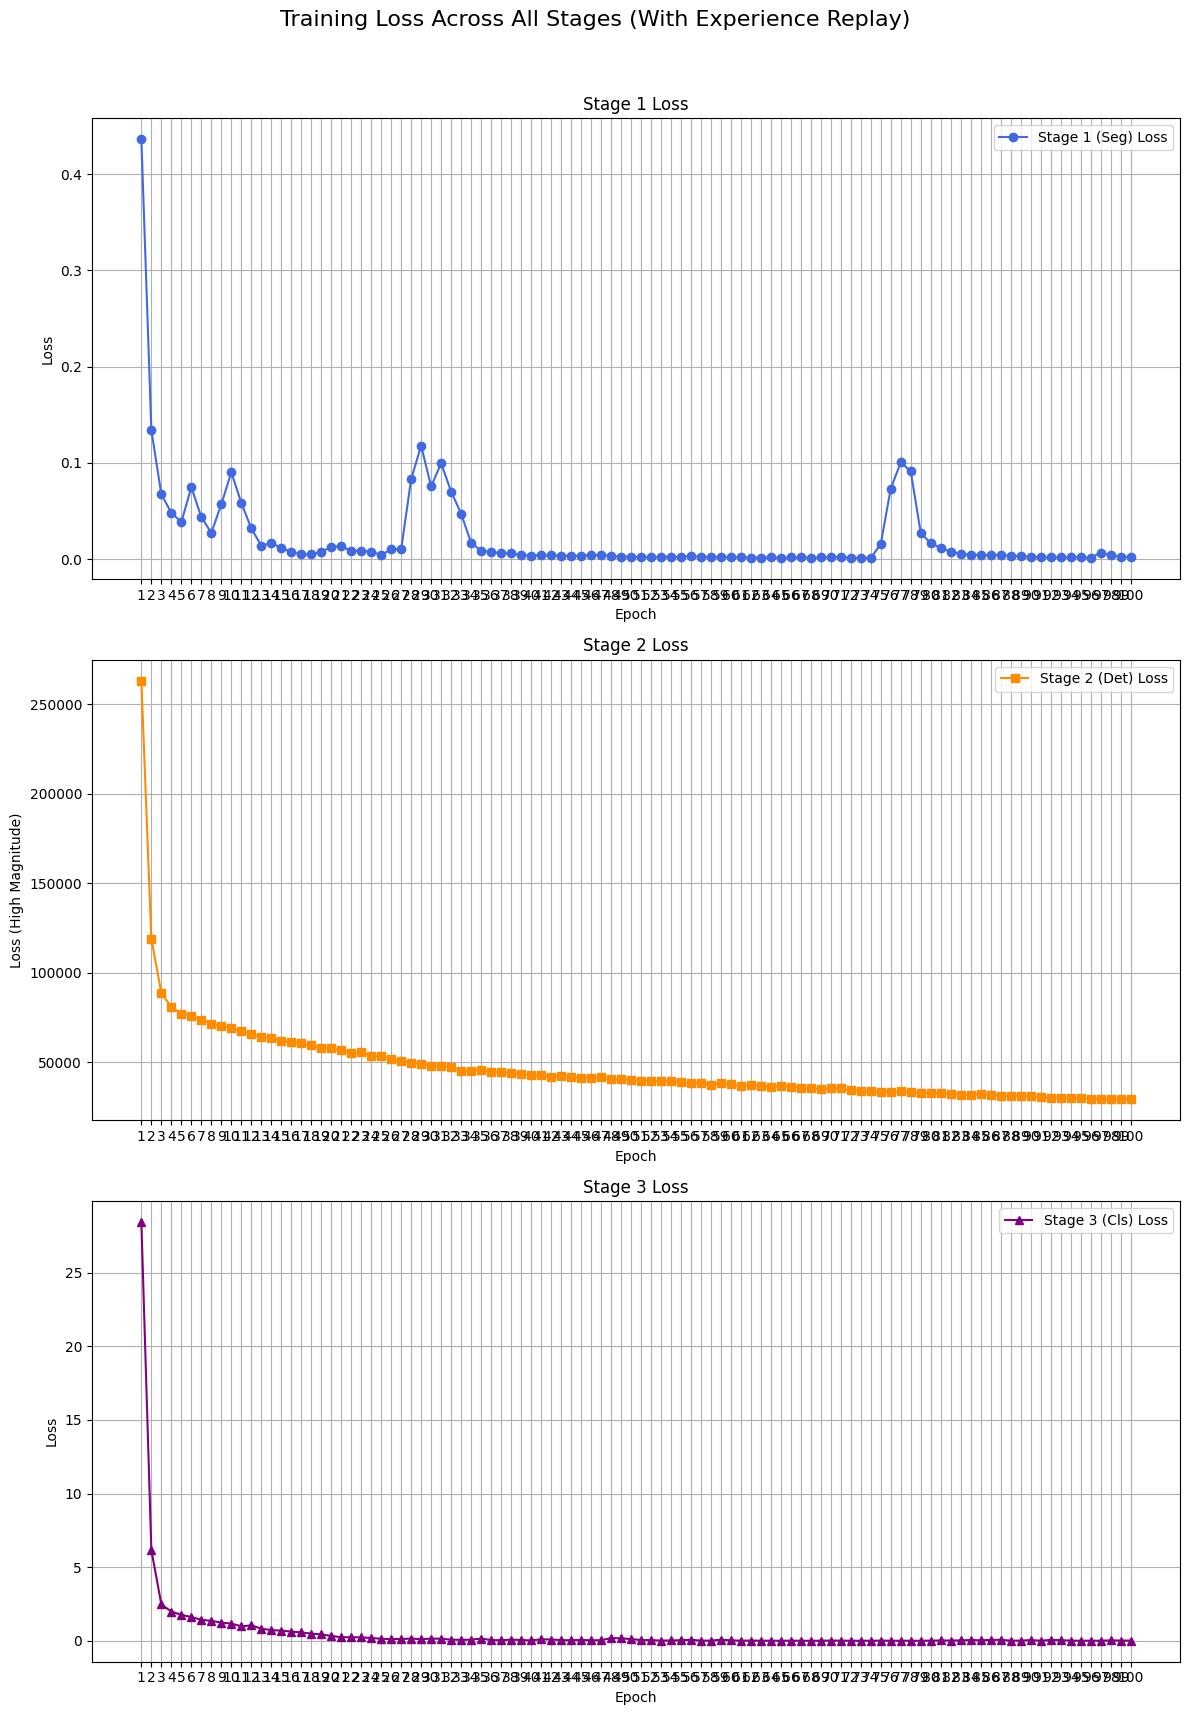

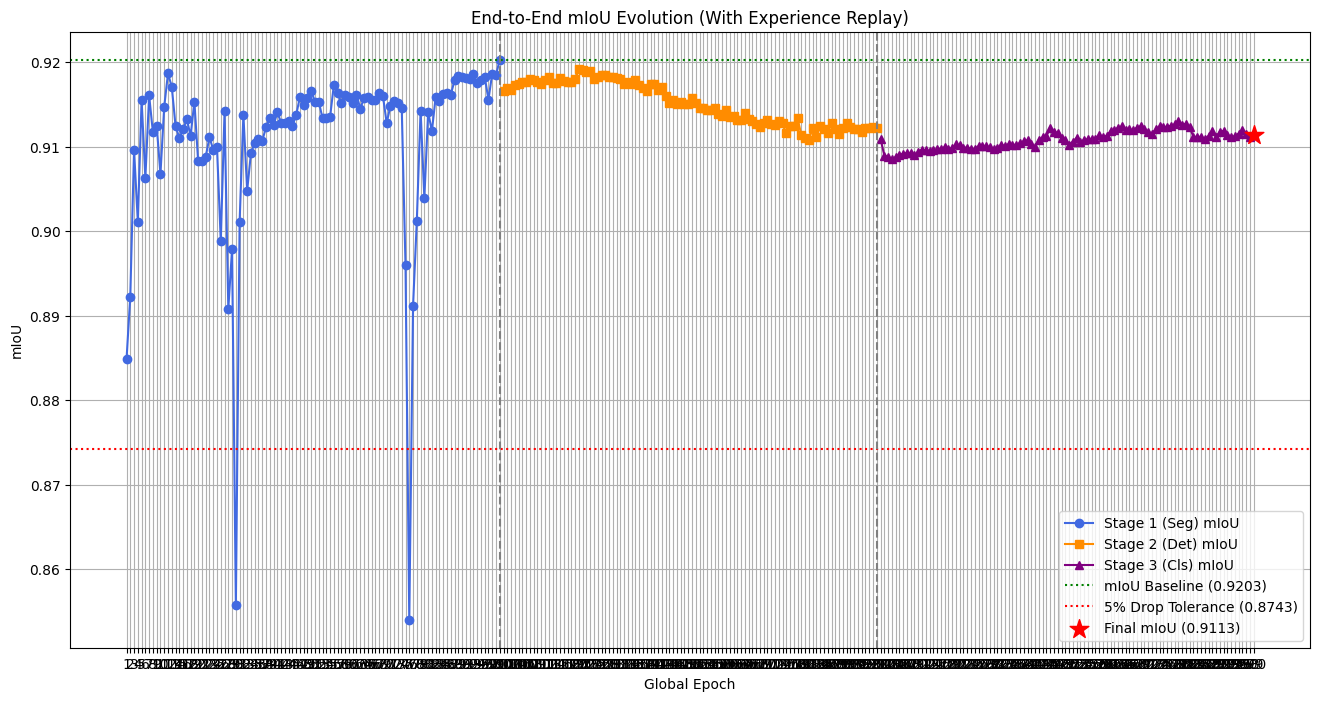

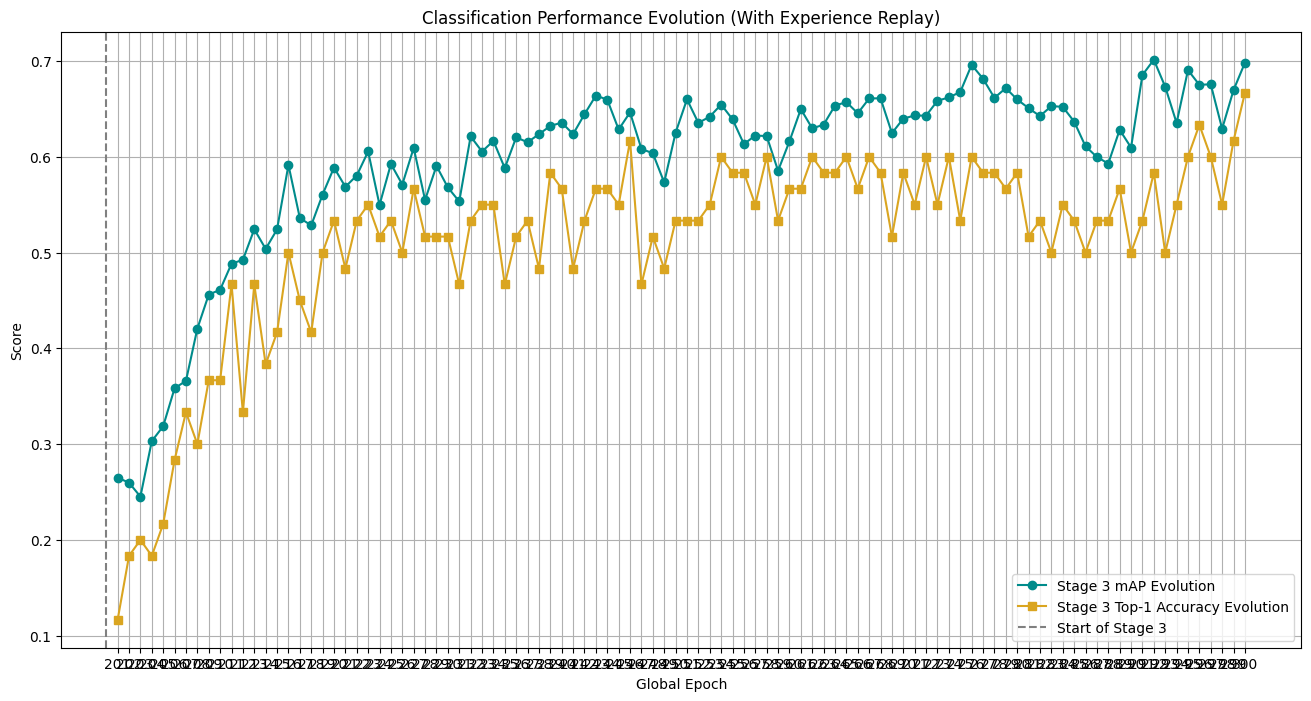

In [4]:
# Cell 2: 呼叫繪圖函式
# 確認 replay_history 變數存在且有內容後，才進行繪圖
if 'replay_history' in locals() and replay_history is not None:
    print("找到實驗結果，正在開始繪圖...")
    plot_training_results(replay_history, experiment_name="With Experience Replay")
else:
    print("❌ 未找到有效的實驗結果 (replay_history)，請先完整執行上一個 Cell 的實驗。")